In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [2]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [3]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2

In [4]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [5]:
# Analyze each day separately or combine them
# data = day_data[DAY_0]
data = combined_data
time_big = data["CROISSANTS"]["timestamp"]

In [6]:
pb2_bid = data["PICNIC_BASKET2"]["bid_price_1"]
pb2_ask = data["PICNIC_BASKET2"]["ask_price_1"]

cro_bid = data["CROISSANTS"]["bid_price_1"]
cro_ask = data["CROISSANTS"]["ask_price_1"]

jams_bid = data["JAMS"]["bid_price_1"]
jams_ask = data["JAMS"]["ask_price_1"]

spread_buy = pb2_ask - (4 * cro_bid + 2 * jams_bid)
spread_sell = pb2_bid - (4 * cro_ask + 2 * jams_ask)

z_score_buy = (spread_buy - np.mean(spread_buy)) / np.std(spread_buy)
z_score_sell = (spread_sell - np.mean(spread_sell)) / np.std(spread_sell)

open_buy_threshold = -1.5
close_buy_threshold = -0.5
open_sell_threshold = 1.5
close_sell_threshold = 0.5

In [7]:
log_file = "../../backtests/newest.log"
trader_data, products_data, activities, trades = process_log(log_file)

sb2 = products_data["SYNTHETIC_BASKET2"]
sb2_buy_spread = sb2["buy_spread"]
sb2_sell_spread = sb2["sell_spread"]
sb2_zscore_buy = sb2["z_score_buy"]
sb2_zscore_sell = sb2["z_score_sell"]

time = sb2["timestamp"]

In [13]:
total_buy_spread = np.concatenate((sb2_buy_spread, spread_buy))
print("Buy spread mean: ", np.mean(total_buy_spread))
print("Buy spread std: ", np.std(total_buy_spread)**2)
total_sell_spread = np.concatenate((sb2_sell_spread, spread_sell))
print("Sell spread mean: ", np.mean(total_sell_spread))
print("Sell spread std: ", np.std(total_sell_spread)**2)

Buy spread mean:  39.32045161290323
Buy spread std:  3667.69782689282
Sell spread mean:  26.00658064516129
Sell spread std:  3668.3182147596253


In [7]:
# True Z-Score (using full dataset)
spread_buy_mean = np.mean(spread_buy)
spread_buy_std = np.std(spread_buy)

spread_sell_mean = np.mean(spread_sell)
spread_sell_std = np.std(spread_sell)

print(f"Buy Spread mean: {spread_buy_mean}")
print(f"Buy Spread var: {spread_buy_std**2}")
print(f"Sell Spread mean: {spread_sell_mean}")    
print(f"Sell Spread var: {spread_sell_std**2}")

Buy Spread mean: 36.89273333333333
Buy Spread var: 3582.762827195555
Sell Spread mean: 23.5792
Sell Spread var: 3583.2907273600003


In [15]:
class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)

true_z_score_buy = (spread_buy - spread_buy_mean) / spread_buy_std
true_z_score_sell = (spread_sell - spread_sell_mean) / spread_sell_std

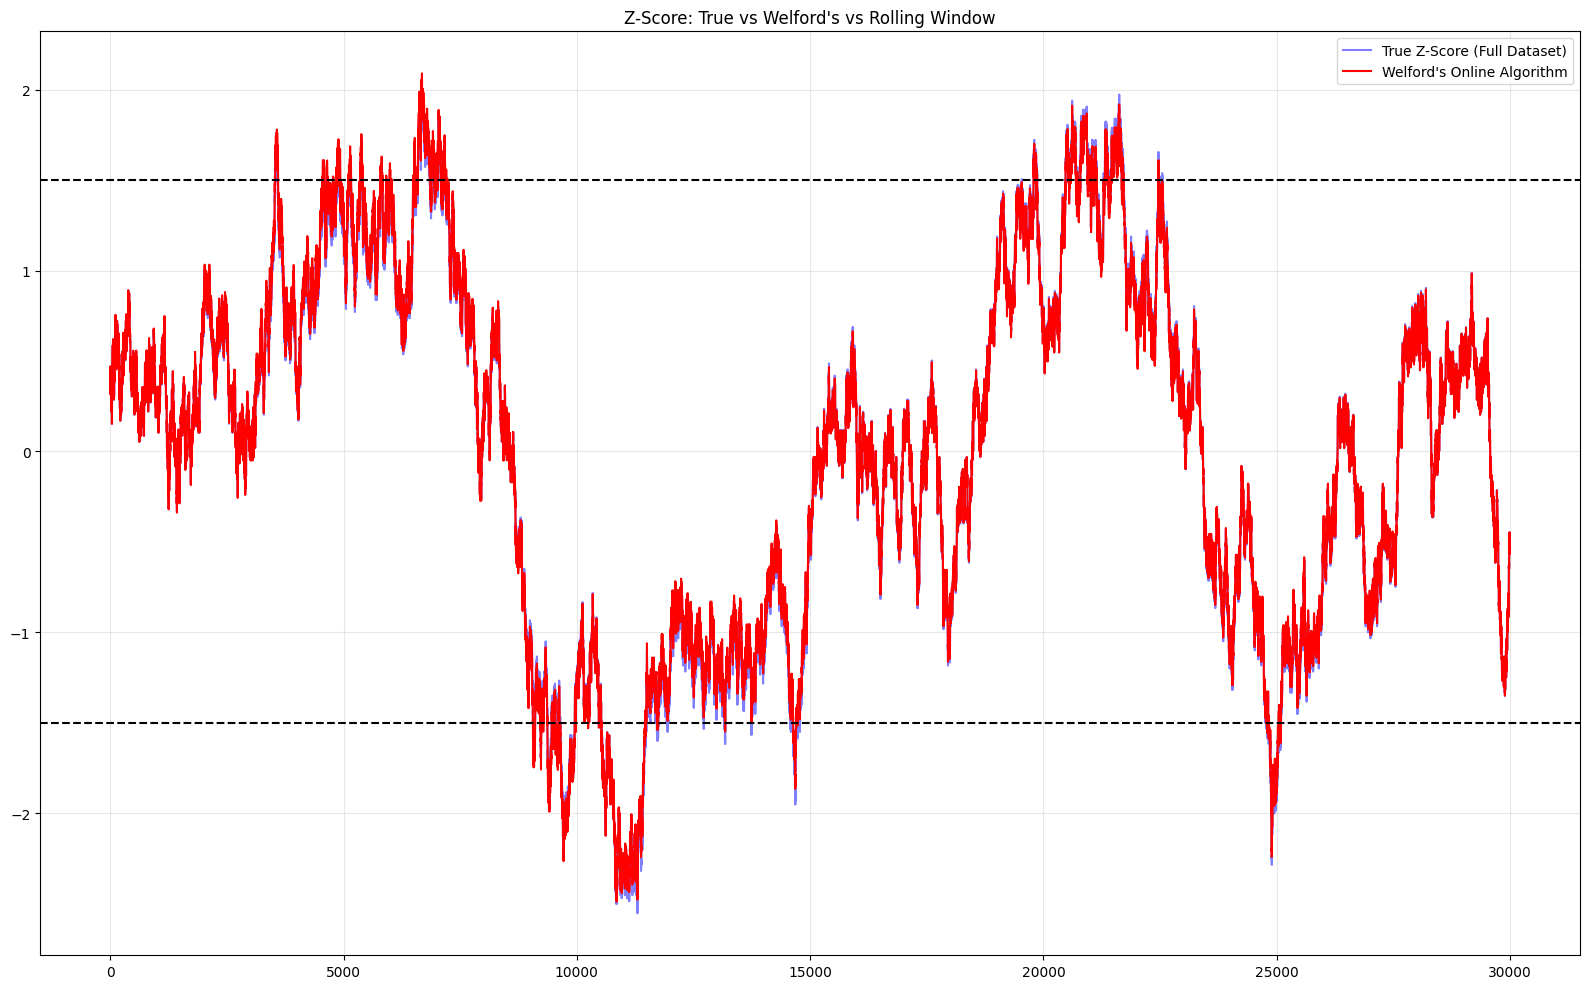

Number of signals (z-score >= 1.5):
True Z-Score: 3591
Welford Z-Score: 3569


In [ ]:
N = 30000

buy_stats = WelfordStatsWithPriors(spread_buy_mean, spread_buy_std**2, N)
sell_stats = WelfordStatsWithPriors(spread_sell_mean, spread_sell_std**2, N)

# Calculate z-scores for each method
z_scores_buy = []
z_scores_sell = []

# Process the data
for i in range(len(spread_buy)):
    # Update statistics
    buy_stats.update(spread_buy[i])
    sell_stats.update(spread_sell[i])
    
    z_buy = (spread_buy[i] - spread_buy_mean) / buy_stats.get_std()
    z_sell = (spread_sell[i] - spread_sell_mean) / sell_stats.get_std()
    z_scores_buy.append(z_buy)
    z_scores_sell.append(z_sell)


# Create dataframe for plotting
df = pd.DataFrame({
    'spread_sell': spread_buy,
    'spread_buy': spread_sell,
    'true_z_score_buy': true_z_score_buy,
    'true_z_score_sell': true_z_score_sell,
    'welford_z_score_buy': z_scores_buy,
    'welford_z_score_sell': z_scores_sell,
})

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

# Plot 2: True Z-Score vs Welford
axes.plot(df['true_z_score_buy'], label='True Z-Score (Full Dataset)', color='blue', alpha=0.5)
axes.plot(df['welford_z_score_buy'], label="Welford's Online Algorithm", color='red')
axes.axhline(y=1.5, color='black', linestyle='--')
axes.axhline(y=-1.5, color='black', linestyle='--')
axes.set_title("Z-Score: True vs Welford's vs Rolling Window")
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Print some statistics about signal generation
signals_true = (abs(df['true_z_score_buy']) >= 1.5).sum()
signals_welford = (abs(df['welford_z_score_buy']) >= 1.5).sum()

print("Number of signals (z-score >= 1.5):")
print(f"True Z-Score: {signals_true}")
print(f"Welford Z-Score: {signals_welford}")